In [0]:
# FOR PLOTTING GRAPHS
import matplotlib.pyplot as plt

# LIBRARIES FOR THE RNN CLASSIFIER
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer

# FOR EVALUATION METRICS OF THE PREDICTIONS
from sklearn.metrics import accuracy_score,f1_score

In [0]:
# IMPORITING THE PARAMENTERS AND SEQUENCES 
import pickle

variables = pickle.load(open('/content/drive/My Drive/tempData/variablesFastText126','rb'))

test_sequence  = variables['test_sequence']
valid_sequence  = variables['valid_sequence']
train_sequence  = variables['train_sequence']

y_train  = variables['y_train']
y_test  = variables['y_test']
y_valid  = variables['y_valid']

MXSEQLEN  = variables['MXSEQLEN']
EMBEDDING_DIM  = variables['EMBEDDING_DIM']
train_embedding_weights  = variables['train_embedding_weights']
train_word_index  = variables['train_word_index']

In [0]:
#####################################################################################
########################## BUILDING AND TRAINING THE MODEL ##########################
#####################################################################################

def RNN(embedding_weights,num_words):
    
    # THE INPUT LAYER
    sequence_input      =   Input(shape=(MXSEQLEN,), dtype='int32')
    
    # THE EMBEDDING LAYER OF EMBEDDING_WEIGHTS     
    embedding_layer = Embedding(
        num_words,                  # VOCABULARY SIZE
        EMBEDDING_DIM,              # ONE HOT ENCODING VECTOR SIZE
        weights=[embedding_weights],# EMBEGGING WEIGHTS FROM THE GOOGLE NEW WORD VECTOR
        input_length=MXSEQLEN,      # MAX LENGTH OF A SEQUENCE
        trainable=False             # PARAMETERS WILL NOT BE TRAINED
    )
    
    # THE EMBEDDING SEQUENCES FROM THE EMBEDDING LAYER 
    embedded_sequences  =   embedding_layer(sequence_input)

    # ADDING ONE LSTM LAYER OF 256 NODES
    lstm_layer = LSTM(256)(embedded_sequences)                    
    
    # DENSE NEURON LAYER
    next_layer = Dense(256, activation='relu')(lstm_layer)        
    
    # FEW DROPOUTS FOR AVOIDING OVERFIT
    next_layer = Dropout(0.3)(next_layer)                         

    next_layer = Dense(64, activation='relu')(next_layer)        

    # FINAL DENSE LAYER
    preds = Dense(1, activation='sigmoid')(next_layer)  

    model = Model(sequence_input, preds)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['acc']
    )
    
    model.summary()
    return model

In [57]:
# len= train_word_index +1 FOR 0 THAT WILL BE PADDED FOR COMPLETING THE SEQUENCE LENGTH
rnn_model = RNN(train_embedding_weights, len(train_word_index)+1)  

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 126)]             0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 126, 300)          1146000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               570368    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65  

In [58]:
# CONFIGURING AND TRAINING THE MODEL
EPOCHS = 10
BATCH_SIZE = 30

history = rnn_model.fit(
    train_sequence,       # THE INPUT SEQUENCES TO THE MODEL
    y_train,              # TARGET OUTPUT
    epochs=EPOCHS,    
    validation_data=(valid_sequence, y_valid), 
    shuffle=True, 
    batch_size=BATCH_SIZE
)

Epoch 1/10
284/284 [==============================] - 5s 17ms/step - loss: 0.4458 - acc: 0.7988 - val_loss: 0.2147 - val_acc: 0.9232
Epoch 2/10
284/284 [==============================] - 5s 16ms/step - loss: 0.3412 - acc: 0.8572 - val_loss: 0.2114 - val_acc: 0.9052
Epoch 3/10
284/284 [==============================] - 5s 17ms/step - loss: 0.3104 - acc: 0.8701 - val_loss: 0.2175 - val_acc: 0.9052
Epoch 4/10
284/284 [==============================] - 4s 16ms/step - loss: 0.2840 - acc: 0.8808 - val_loss: 0.1897 - val_acc: 0.9196
Epoch 5/10
284/284 [==============================] - 5s 16ms/step - loss: 0.2721 - acc: 0.8847 - val_loss: 0.2265 - val_acc: 0.8968
Epoch 6/10
284/284 [==============================] - 4s 16ms/step - loss: 0.2424 - acc: 0.8986 - val_loss: 0.2141 - val_acc: 0.9112
Epoch 7/10
284/284 [==============================] - 4s 16ms/step - loss: 0.2185 - acc: 0.9091 - val_loss: 0.2302 - val_acc: 0.9088
Epoch 8/10
284/284 [==============================] - 4s 16ms/step - 

In [0]:
#####################################################################################
########################## ANALYZING AND TWEAKING THE MODEL##########################
#####################################################################################

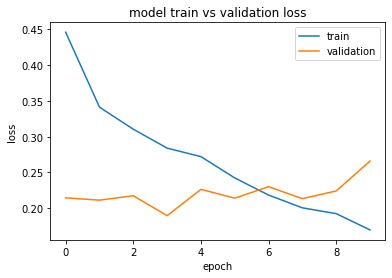

In [59]:
# TRAINING VS VALIDATION LOSS GRAPH
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [60]:
predict=rnn_model.predict(test_sequence)
predict=[int(x+0.5) for x in predict]

# EVLUATING THE ACCURACY
accuracy = accuracy_score(y_test, predict)
f1=f1_score(y_test,predict)
print("F1 Score: %.2f%%" % (f1* 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

F1 Score: 77.76%
Accuracy: 77.87%
